# P-P plots (no selection effect)

## P-P plots Gaussian

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import emcee
import warnings
import corner
import pandas as pd
import bilby
warnings.filterwarnings("ignore")

In [2]:
MU_P_LOW = 0
MU_P_HIGH = 5
SIGAM_P_LOW = 0
SIGMA_P_HIGH = 1

priors = {"mu_p": bilby.core.prior.Uniform(MU_P_LOW, MU_P_HIGH, "mu_p"), 
          "sigma_p": bilby.core.prior.Uniform(SIGAM_P_LOW, SIGMA_P_HIGH, "sigma_p")}

In [3]:
N_obs = 500
size_child = 50
true_child_scale = 0.5

NRES = 20

RESULTS = []

In [4]:
def log_hyperprior(params):
    parent_mean, parent_scale = params
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 1):
        return 0.0
    return -np.inf

def log_likelihood(params):
    parent_mean, parent_scale = params
    return np.log(np.prod(size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(true_child_gaussian - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))

def log_probability(params):
    log_prior_val = log_hyperprior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

100%|██████████| 1000/1000 [00:02<00:00, 428.25it/s]


Too few points to create valid contours


100%|██████████| 1000/1000 [00:01<00:00, 916.01it/s]


Too few points to create valid contours


100%|██████████| 1000/1000 [00:01<00:00, 918.10it/s]


Too few points to create valid contours


100%|██████████| 1000/1000 [00:02<00:00, 467.72it/s]
11:53 bilby INFO    : Key: KS-test p-value
11:53 bilby INFO    : mu_p: 0.24937743218434005
11:53 bilby INFO    : sigma_p: 1.876874035333163e-09
11:53 bilby INFO    : Combined p-value: 1.052290943474732e-08


(<Figure size 640x480 with 1 Axes>,
 pvals(combined_pvalue=1.052290943474732e-08, pvalues=[0.24937743218434005, 1.876874035333163e-09], names=['mu_p', 'sigma_p']))

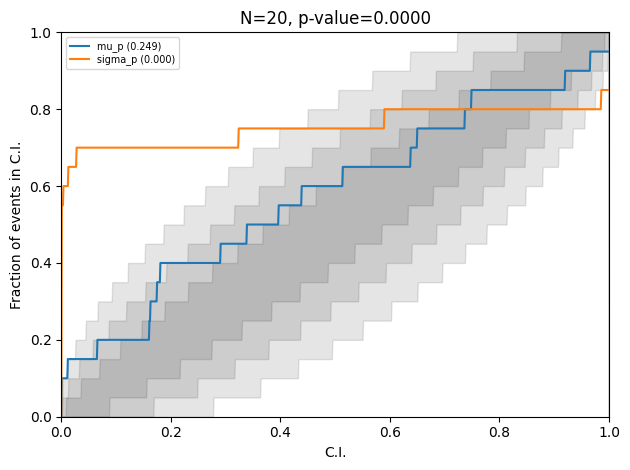

In [5]:


for ii in range(NRES):
    injections = dict()
    posterior = dict()
    
    for key, prior in priors.items():
        injections[key] = prior.sample()
    
    true_parent_gaussian = np.random.normal(loc=injections["mu_p"], scale=injections["sigma_p"], size=N_obs)
    err_on_mean_child = np.expand_dims(np.random.randn(N_obs)*true_child_scale, axis=1)
    true_child_gaussian = np.random.normal(loc=true_parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

    pos = np.array([injections["mu_p"], injections["sigma_p"]]) + 0.1 * np.random.randn(2) + 1e-6 * np.random.randn(20, 2)
    nwalkers, ndim = pos.shape

    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability, pool=pool,
        )
        sampler.run_mcmc(pos, 1000, progress=True)

    flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
    posterior = {"mu_p": flat_samples[:,0], "sigma_p": flat_samples[:,1]}
    
    posterior = pd.DataFrame(dict(posterior))
    posterior.to_csv(f'PP-plot-test/Single-Gaussian/samples/run{ii+1}.txt', sep='\t')
        
    result = bilby.result.Result(
        label="PPtest",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=injections.keys(),
        priors=priors)
    
    RESULTS.append(result)

    fig = corner.corner(flat_samples, labels=["mu_p", "sigma_p"], truths=[injections["mu_p"], injections["sigma_p"]], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12})
    plt.savefig('PP-plot-test/Single-Gaussian/corner-plot/run_'+str(ii+1)+'.png')
    plt.close()
        
bilby.result.make_pp_plot(RESULTS, filename=f"Single-Gaussian/PP-Plot", confidence_interval=[0.68, 0.95, 0.997])

## P-P straight line

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import emcee
import warnings
import corner
import pandas as pd
import bilby
warnings.filterwarnings("ignore")

In [7]:
NRES = 20
N = 50

M_LOW = -5
M_HIGH = -2
B_LOW = 1
B_HIGH = 5

priors = {"m": bilby.core.prior.Uniform(M_LOW, M_HIGH, "m"), 
          "b": bilby.core.prior.Uniform(B_LOW, B_HIGH, "b")}

RESULTS = []

In [8]:
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    m, b = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

100%|██████████| 1000/1000 [00:01<00:00, 946.70it/s]
11:53 bilby INFO    : Key: KS-test p-value
11:53 bilby INFO    : m: 0.09940000292262607
11:53 bilby INFO    : b: 0.6792622424816818
11:53 bilby INFO    : Combined p-value: 0.24950519026407245


(<Figure size 640x480 with 1 Axes>,
 pvals(combined_pvalue=0.24950519026407245, pvalues=[0.09940000292262607, 0.6792622424816818], names=['m', 'b']))

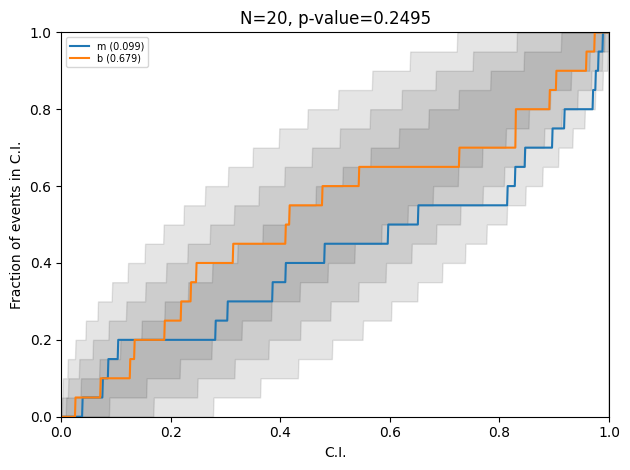

In [9]:
for ii in range(NRES):
    injections = dict()
    posterior = dict()
    
    for key, prior in priors.items():
        injections[key] = prior.sample()


    x = np.sort(10 * np.random.rand(N))
    yerr = 0.1 + np.random.rand(N)
    y = injections["m"] * x + injections["b"]
    y += yerr * np.random.randn(N)

    pos = np.array([injections["m"], injections["b"]]) + 0.1 * np.random.randn(2) + 1e-4 * np.random.randn(10, 2)
    nwalkers, ndim = pos.shape
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr), pool=pool)
        sampler.run_mcmc(pos, 1000, progress=True)
    
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    posterior = {"m": flat_samples[:,0], "b": flat_samples[:,1]}
    # print(injections["m"], injections["b"], flat_samples.mean(axis=0), posterior["m"], posterior["b"])

    posterior = pd.DataFrame(dict(posterior))
    # print(posterior)
    posterior.to_csv(f'PP-plot-test/Straight-line/samples/run{ii+1}.txt', sep='\t')
        
    result = bilby.result.Result(
        label="PPtest",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=injections.keys(),
        priors=priors)
    
    RESULTS.append(result)

    fig = corner.corner(flat_samples, labels=["m", "b"], truths=[injections["m"], injections["b"]], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12})
    plt.savefig('PP-plot-test/Straight-line/corner-plot/run_'+str(ii+1)+'.png')
    plt.close()
        
bilby.result.make_pp_plot(RESULTS, filename=f"Straight-line/PP-Plot", confidence_interval=[0.68, 0.95, 0.997])

## from Greg Ashton webpage

https://greg-ashton.physics.monash.edu/understanding-pp-plots.html

In [5]:
import numpy as np
import bilby
from bilby.core.prior import Uniform
import pandas as pd
import tqdm

np.random.seed(1234)
sigma = 1
Nresults = 5
Nsamples = 10
Nparameters = 2
Nruns = 1

priors = {f"x{jj}": Uniform(-1, 1, f"x{jj}") for jj in range(Nparameters)}


for x in range(Nruns):
    results = []
    for ii in tqdm.tqdm(range(Nresults)):
        posterior = dict()
        injections = dict()
        for key, prior in priors.items():
            sim_val = prior.sample()
            injections[key] = sim_val
            rec_val = sim_val + np.random.normal(0, sigma)
            posterior[key] = np.random.normal(rec_val, sigma, Nsamples)
        # print(injections["x0"], injections["x1"], posterior["x0"], posterior["x1"])

        posterior = pd.DataFrame(dict(posterior))
        print(posterior)
        result = bilby.result.Result(
            label="test",
            injection_parameters=injections,
            posterior=posterior,
            search_parameter_keys=injections.keys(),
            priors=priors)
        results.append(result)

    # bilby.result.make_pp_plot(results, filename=f"run{x}_90CI",
    #                           confidence_interval=0.9)
    # bilby.result.make_pp_plot(results, filename=f"run{x}_3sigma",
    #                           confidence_interval=[0.68, 0.95, 0.997])


100%|██████████| 5/5 [00:00<00:00, 1288.49it/s]

         x0        x1
0 -0.210584  1.325142
1  2.413099 -1.649437
2  0.667740  0.037741
3  0.259803  0.373936
4  1.867555  0.777272
5  1.839980  0.660910
6  0.343869  1.692976
7  0.996088 -1.175087
8 -1.262293  0.169172
9  2.130428 -0.284151
         x0        x1
0  1.598410  1.303649
1  2.363123  0.317841
2  0.575666  0.564645
3  1.720525  0.117137
4 -0.772056  1.281607
5  0.861863  2.830893
6  2.103940  0.516132
7  0.647131 -0.126514
8  1.382409  0.476074
9  2.092550 -1.635045
         x0        x1
0 -0.251439 -0.472834
1  0.508922 -0.862367
2  0.664007 -0.261116
3  1.401131  0.718805
4  0.860986 -1.801090
5  1.486726 -0.897199
6 -0.800093 -0.518885
7 -0.756256 -1.035353
8  0.544799  0.206947
9  0.097475 -3.227308
         x0        x1
0  0.663514 -0.530229
1  2.018029 -1.122696
2  2.510866 -0.697816
3  1.020710 -4.725725
4  2.268205  0.158897
5  2.510374 -1.009578
6  2.329653 -0.997679
7  0.879891 -1.592304
8  3.813988 -0.394840
9  2.033108 -0.177289
         x0        x1
0  1.47956

# testing Bilby

In [ ]:
import bilby
import numpy as np

# A few simple setup steps
label = "hierarchical_model"
outdir = "outdir"
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)


true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter

true_child_scale = 0.5

N_obs = 500
size_child = 100

# Hypothesis for parent gaussian 
## draws from parent  for mu child
true_parent_gaussian = np.random.normal(loc=true_parent_mean, scale=true_parent_scale, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)*true_child_scale, axis=1)
true_child_gaussian = np.random.normal(loc=true_parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

class SimpleGaussianHMLikelihood(bilby.Likelihood):
    def __init__(self, data):
        super().__init__(parameters={"mu_p": None, "sigma_p": None})
        self.data = data

    def log_likelihood(self):
        parent_mean = self.parameters["mu_p"]
        parent_scale = self.parameters["sigma_p"]
        return np.log(np.prod(size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(self.data - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))

log_likelihood = SimpleGaussianHMLikelihood(true_child_gaussian)
priors = dict(
    mu_p=bilby.core.prior.Uniform(-5, 5, "mu_p"),
    sigma_p=bilby.core.prior.Uniform(0, 1, "sigma_p"),
)

# And run sampler
result = bilby.run_sampler(
    likelihood=log_likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=1000,
    outdir=outdir,
    label=label,
)
result.plot_corner(parameters=["mu_p", "sigma_p"], truths=[true_parent_mean, true_parent_scale])

In [ ]:
result.samples

In [ ]:
result.samples.shape

In [ ]:
len(result.samples[:, 0])

# Selection effects test

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter

true_child_scale = 0.1

N_obs = 500
size_child = 100

# Hypothesis for parent gaussian 
## draws from parent  for mu child
true_parent_gaussian = np.random.normal(loc=true_parent_mean, scale=true_parent_scale, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)*true_child_scale, axis=1)
true_child_gaussian = np.random.normal(loc=true_parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

# adding selection effect
true_child_gaussian_observed = []
for i in range(len(true_parent_gaussian)):
    # print(true_child_gaussian[i].mean() > true_parent_mean - true_parent_scale  and  true_child_gaussian[i].mean() < true_parent_mean + true_parent_scale)
    if (true_child_gaussian[i].mean() > true_parent_mean - 2 * true_parent_scale and 
        true_child_gaussian[i].mean() < true_parent_mean + 2 * true_parent_scale):
        true_child_gaussian_observed.append(true_child_gaussian[i])
true_child_gaussian_observed = np.array(true_child_gaussian_observed)

In [3]:
true_child_gaussian_observed.shape

(474, 100)

In [4]:
true_child_gaussian.shape

(500, 100)

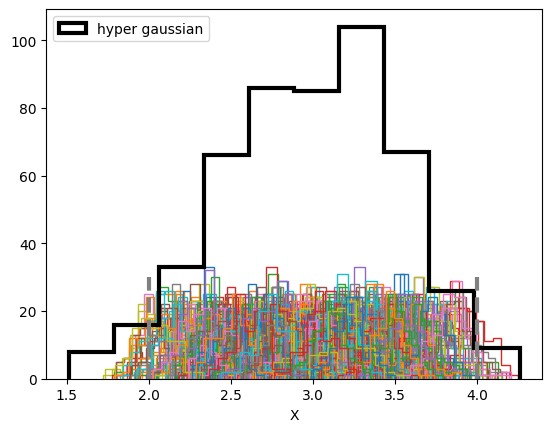

In [5]:
for i in range(len(true_child_gaussian_observed)):
    plt.hist(true_child_gaussian_observed[i], fill=False, histtype='step')
    # plt.hist(true_child_gaussian[i], fill=False, histtype='step')
    # plt.vlines(np.mean(true_child_gaussian[i]), 0, size_child, linestyles='-.', alpha=0.3)
plt.hist(true_parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian')
plt.vlines(true_parent_mean - 2 * true_parent_scale, 0, 30, linestyles='--', color='grey',linewidth=3)
plt.vlines(true_parent_mean + 2 * true_parent_scale, 0, 30, linestyles='--', color='grey',linewidth=3)
plt.xlabel("X")
plt.legend()

In [6]:
def model(params, data):
    parent_mean, parent_scale = params
    return size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(data - parent_mean)**2 / (2 * parent_scale**2)), axis=1)

def alpha(data):
    return len(data)**-1 * np.sum(np.ones(len(data)))

def log_hyperprior(params):
    parent_mean, parent_scale = params
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 1):
        return 0.0
    return -np.inf

def log_likelihood(params):
    return np.log(np.prod(model(params, true_child_gaussian_observed) / alpha(true_child_gaussian_observed)))

def log_probability(params):
    log_prior_val = log_hyperprior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [7]:
pos = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2) + 1e-6 * np.random.randn(20, 2)
nwalkers, ndim = pos.shape

#from multiprocessing import Pool

#with Pool() as pool:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,
)
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:29<00:00, 170.32it/s]


State([[3.00343909 0.47490348]
 [2.99327778 0.44901577]
 [3.02650093 0.47893996]
 [3.02494623 0.4656657 ]
 [2.9990573  0.46159127]
 [2.97272704 0.45821534]
 [3.02400427 0.43179794]
 [3.01002246 0.46281693]
 [3.03996214 0.46297671]
 [3.02293862 0.47290252]
 [3.02083498 0.44474902]
 [3.02955624 0.44538392]
 [2.99486249 0.42850313]
 [2.96854547 0.46229943]
 [3.01577942 0.45566222]
 [3.0160861  0.46108864]
 [3.02107951 0.4673205 ]
 [3.0013672  0.45620729]
 [3.0396465  0.46443946]
 [3.01890916 0.4678655 ]], log_prob=[-314.21754301 -313.95716435 -315.07951031 -314.32727317 -313.7142457
 -314.62203802 -315.84185202 -313.78610074 -315.22706331 -314.53139245
 -314.47353911 -314.89030484 -315.78222464 -314.91817974 -313.89571208
 -313.9006967  -314.21038422 -313.69216501 -315.22461965 -314.14967001], blobs=None, random_state=('MT19937', array([1467831461, 2598359392,  791868242, 1194537775, 3629288783,
         79306978, 1318002894, 3013676414, 2455720160, 1969498141,
       2193829830, 29465175

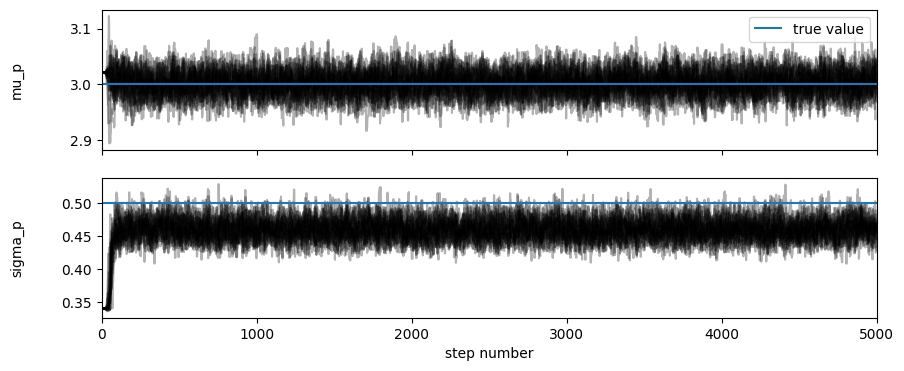

In [8]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [9]:
tau = sampler.get_autocorr_time()
print(tau)

[29.76200345 45.77947566]


In [10]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(6600, 2)


In [11]:
np.mean(flat_samples[:,0])

3.0022352335063283

In [12]:
np.mean(flat_samples[:,1])

0.4601874392389771

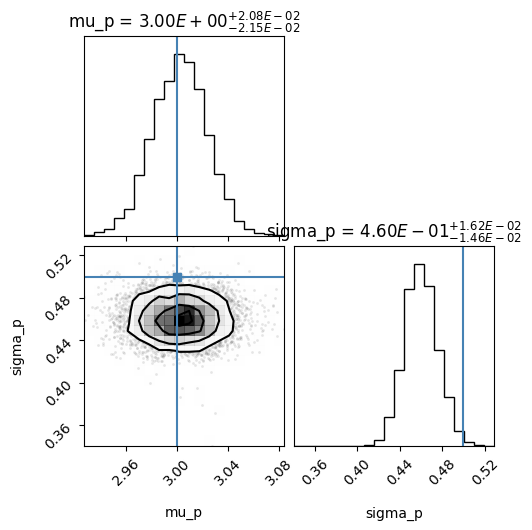

In [13]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)